## Import

In [2]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

%matplotlib inline

# Set seaborn style for professional plots
sns.set_style("darkgrid")  # Options: darkgrid, whitegrid, dark, white, ticks
sns.set_palette("husl")  # Set color palette

## DJIA_table.csv

In [3]:
data = pd.read_csv('data/raw/DJIA_table.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1989 non-null   datetime64[ns]
 1   Open       1989 non-null   float64       
 2   High       1989 non-null   float64       
 3   Low        1989 non-null   float64       
 4   Close      1989 non-null   float64       
 5   Volume     1989 non-null   int64         
 6   Adj Close  1989 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 108.9 KB


In [5]:
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
2,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
3,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
4,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688


### some plots

In [6]:
def plot_price(data, window=None, x_ticks=True, col="Close", ax=None):
    # Create figure only if no axis is provided
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 6))
    
    # Make background transparent
    ax.patch.set_alpha(0.7)  # Fully transparent axes background

    if window:
        data = data.loc[(data['Date'] >= window[0]) & (data['Date'] <= window[1])]

    # Top plot: Closing Price
    ax.plot(data['Date'], data[col], label=f'{col}', 
            color='#2E86AB', linewidth=1.5, alpha=0.9)

    # Styling for price plot
    ax.set_ylabel(f'{col}', fontsize=14, fontweight='bold')
    ax.grid(True, linestyle='--')
    ax.legend(framealpha=0.9)

    # Format x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    
    # Remove x-axis ticks if specified
    if not x_ticks:
        ax.set(xticklabels=[])
    else:
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right') 
        
    return ax

Text(0.5, 1.0, 'DJIA Trading Time Series')

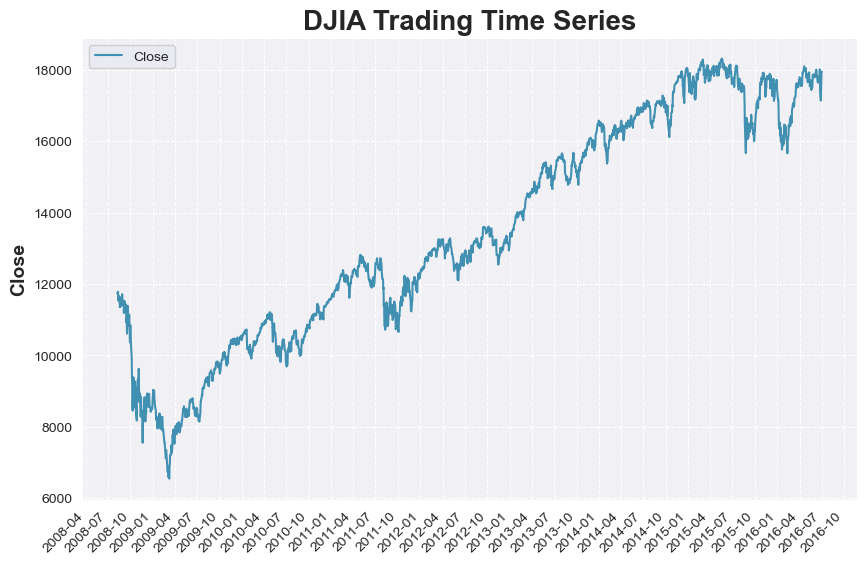

In [8]:
window = None
ax = plot_price(data, window)
plt.title("DJIA Trading Time Series", fontsize=20, fontweight='bold')




In [ ]:
def plot_volume(data, window=None):
    _, ax = plt.subplots(figsize=(10, 6))
    red, green = '#DC3545', '#28A745'
    if window:
        data = data.loc[(data['Date'] >= window[0]) & (data['Date'] <= window[1])]
    
    colors = [green if data.loc[i, 'Close'] >= data.loc[i, 'Open'] 
            else red for i in range(len(data))]
    ax.bar(data['Date'], data['Volume'], color=colors, alpha=0.6, width=1)
    ax.set_ylabel('Volume', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')

    # Format x-axis dates for volume plot
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')


# plt.tight_layout()
# plt.show()


<IPython.core.display.Javascript object>

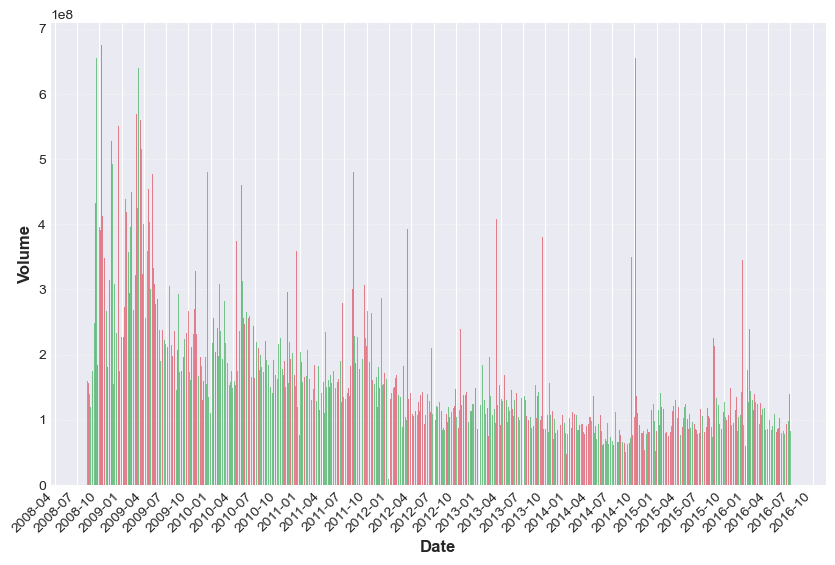

In [93]:
plot_volume(data)

### Dollar volume

In [35]:
data['Dollar Volume'] = data['Volume'] * data['Close']/1e6
data['Dollar Volume'] 

0       2.497415e+06
1       2.158409e+06
2       2.021016e+06
3       2.105342e+06
4       1.856109e+06
            ...     
1984    2.378037e+06
1985    1.953197e+06
1986    1.882360e+06
1987    2.385227e+06
1988    1.474720e+06
Name: Dollar Volume, Length: 1989, dtype: float64

## Volatily Indicators

### Average True Range (ATR)

In [20]:
days = 14
atr = ta.atr(high=data['High'], 
            low=data['Low'], 
            close=data['Close'], 
            length=days)
data['ATR'] = atr.sub(atr.mean()).div(atr.std())


/var/folders/rf/k6h69xrd5zndck3m2hy3dqnm0000gn/T/ipykernel_3623/1786154519.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


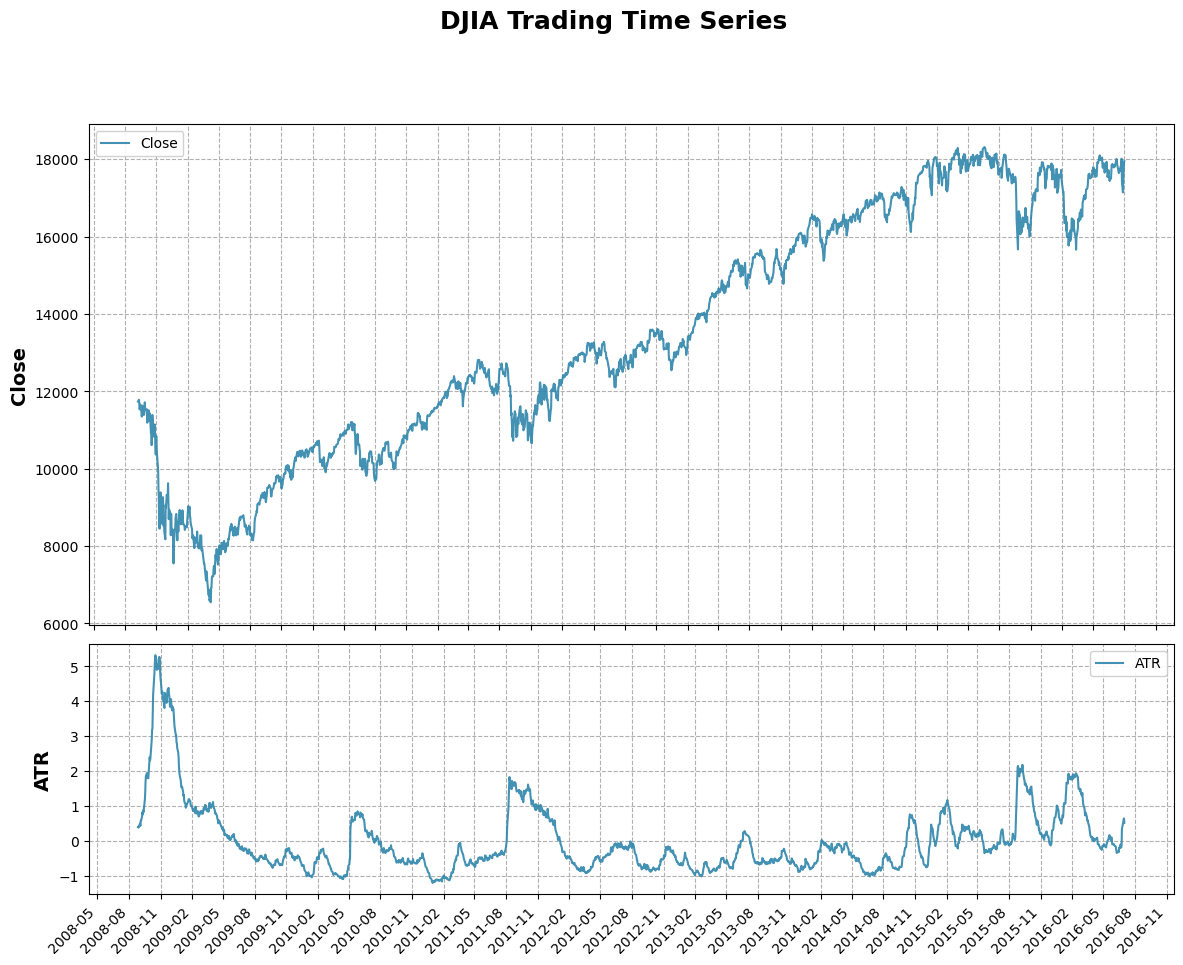

In [24]:
window = None

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), 
                                gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

# Add title to the figure
fig.suptitle('DJIA Trading Time Series', fontsize=18, fontweight='bold', y=0.995)

# Plot Close price on top subplot
plot_price(data, window, x_ticks=False, col="Close", ax=ax1)

# Plot ATR on bottom subplot
plot_price(data, window, x_ticks=True, col='ATR', ax=ax2)

plt.tight_layout()
plt.show()



### Bollinger Bands

- A volatility-based envelope around price
- They show volatility expansions and contractions and potential overbought/oversold conditions.

Maybe use log(Adj Close) before applying bbands (to have volatility in percentages.). The bands remain proportional to the asset's growth rate rather than its raw price level. (variance stabilization)

$ln(1+r) \approx r$ and $r = \frac{P_t - P_{t-1}}{P_t}$

**Conclusion:** The difference between log prices is approximately equal to the simple percentage return.

In [16]:
# from pandas_ta
bb_low_tab = ta.bbands(np.log1p(data['Adj Close']) , length=20, std=2)


In [17]:
days = 20
log_adj_close = np.log1p(data['Adj Close'])
sma = log_adj_close.rolling(window=days).mean()
k = 2
bb_low = sma - k * log_adj_close.rolling(window=days).std()
bb_high = sma + k * log_adj_close.rolling(window=days).std()
bb_mid = (bb_low + bb_high) / 2

data["bb_low"] = bb_low
data["bb_high"] = bb_high
data["bb_mid"] = bb_mid


### Garman-Klass Volatily (GKV) 

In [4]:
op_left = ((np.log(data['High']) - np.log(data['Low']))**2)/2 
op_right = (2*np.log(2)-1)*(np.log(data['Adj Close']) - np.log(data['Open']))**2
data['GKV'] = op_left - op_right

### Moving Average Convergence Divergence (MACD)

It shows trend direction, strength, and momentum shifts.

- MACD line $= EMA_{12} - EMA_{26}$
- Signal line $= EMA_{9}(MACD line)$

In [31]:
days = 12
macd = ta.macd(data['Adj Close'], length=days).iloc[:, 0]
macd 
data["MACD"] = macd.sub(macd.mean()).div(macd.std())

## Momemtum indicators

### Relative Strenght Index (RSI)



A momentum oscillator from 0–100 measuring speed and magnitude of price changes.

Up periods:

- $U = close_{now} - close_{previous}$
- $D = 0$

Down periods:

- $U = 0$
- $D = close_{previous} - close_{now}$

$RSI = 100 - \frac{100}{1+RS}$, $RS=\frac{SMMA(U, n)}{SMMA(D, n)}$

In [19]:
#with pandas_ta
days = 14
data["RSI"] = ta.rsi(data['Adj Close'], length=days)


#with pandas

In [18]:
days = 14
smma = ta.smma(data['Adj Close'], length=days)

### Month return (To Finish)

- **to change, dataset smaller to compute month return**
- **consider week return or day return ??**

In [ ]:
outlier_cutoff = 0.05
lags = [1, 2, 3, 6, 9, 12]

for lag in lags:
    data[f"return_{lag}m"] = data["Adj Close"]     \
                            .pct_change(periods=lag)\
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), 
                                                   upper=x.quantile(1-outlier_cutoff)))\
                            .add(1) \
                            .pow(1/lag) \
                            .sub(1)

    







### Fama-french indicators